In [1]:
import rioxarray as riox
import xarray as xr
import os
import geopandas as gpd
from datetime import datetime, timedelta

In [2]:
prefix = 'cper'
yr = 2014
outDIR = os.path.join('/90daydata/cper_neon_aop/cper_hls_veg_models/data/lmf_cper')
nc_f = os.path.join(outDIR, 'CPER_2014.Landsat_MODIS_STARFM.nc')

# the path to a shapefile with CPER pasture boundaries
cper_f = '../data/ground/boundaries/cper_pastures_2017_dissolved.shp'

In [3]:
# prepare the pasture boundaries to be converted into an xarray mask
cper = gpd.read_file(cper_f).to_crs(32613)
#cper_info = cper[['Pasture', 'geometry']].reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
#past_dict = {row.id+1: row.Pasture for _, row in cper_info.iterrows()}
#past_dict[0] = 'UNK'
#cper_mask_shp = [(row.geometry, row.id+1) for _, row in cper_info.iterrows()]

In [41]:
from dask.distributed import LocalCluster, Client
import dask
from jupyter_server import serverapp
try:
    jupServer = [x for x in serverapp.list_running_servers()][0]
    dask.config.set({'distributed.dashboard.link': 'https://atlas-ood.hpc.msstate.edu' + jupServer['base_url'] + 'proxy/{port}/status'})
except:
    pass
cluster = LocalCluster(n_workers=16, threads_per_worker=2)
client = Client(cluster)
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://atlas-ood.hpc.msstate.edu/node/atlas-0073/37414/proxy/8787/status,
Dashboard: https://atlas-ood.hpc.msstate.edu/node/atlas-0073/37414/proxy/8787/status,Workers: 16
Total threads: 32,Total memory: 240.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34139,Workers: 16
Dashboard: https://atlas-ood.hpc.msstate.edu/node/atlas-0073/37414/proxy/8787/status,Total threads: 32
Started: 1 minute ago,Total memory: 240.19 GiB
Comm: tcp://127.0.0.1:45757,Total threads: 2
Dashboard: https://atlas-ood.hpc.msstate.edu/node/atlas-0073/37414/proxy/36243/status,Memory: 15.01 GiB
Nanny: tcp://127.0.0.1:33657,


In [42]:
#cluster.close()
#client.close()

In [183]:
hls_ds = xr.open_dataset(nc_f, chunks={'DOY': -1, 'y': 20, 'x': 20})

In [184]:
#hls_ds.rio.

In [185]:
if hls_ds.rio.crs != cper.crs:
    hls_ds = hls_ds.rio.reproject(cper.crs)
# convert the band coordinate to date
hls_ds['DOY'] = [datetime(yr, 1, 1) + timedelta(days=int(x)-1) for x in hls_ds['DOY'].values]
# rename band coordinate to date
hls_ds = hls_ds.rename({'DOY': 'time'})
# subset to only CPER boundaries
hls_ds = hls_ds.sel(x=slice(cper.total_bounds[0], cper.total_bounds[2] + 30),
                    y=slice(cper.total_bounds[3], cper.total_bounds[1] - 30))

In [186]:
hls_ds

<xarray.Dataset>
Dimensions:  (time: 365, y: 323, x: 323)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01 2014-01-02 ... 2014-12-31
  * y        (y) float64 4.524e+06 4.524e+06 4.524e+06 ... 4.515e+06 4.515e+06
  * x        (x) float64 5.176e+05 5.176e+05 5.177e+05 ... 5.272e+05 5.273e+05
    YEAR     int32 ...
Data variables:
    BLUE     (time, y, x) int16 dask.array<chunksize=(365, 20, 10), meta=np.ndarray>
    GREEN    (time, y, x) int16 dask.array<chunksize=(365, 20, 10), meta=np.ndarray>
    RED      (time, y, x) int16 dask.array<chunksize=(365, 20, 10), meta=np.ndarray>
    NIR1     (time, y, x) int16 dask.array<chunksize=(365, 20, 10), meta=np.ndarray>
    SWIR1    (time, y, x) int16 dask.array<chunksize=(365, 20, 10), meta=np.ndarray>
    SWIR2    (time, y, x) int16 dask.array<chunksize=(365, 20, 10), meta=np.ndarray>

In [187]:
hls_ds = hls_ds.where(hls_ds != -9999)

In [156]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [157]:
from scipy.signal import find_peaks

In [196]:
def despike_lmf_mask(swir_ts, min_prominence=0.2, low_prominence=0.05):
    try:
        ts = pd.Series(swir_ts*-1.0).interpolate()
        pks = find_peaks(ts, prominence=low_prominence)
        for i in range(len(pks[0])):
            if pks[1]['prominences'][i] > min_prominence:
                #print(i)
                pk = pks[0][i]
                if i > 0 and pks[1]['prominences'][i-1] < min_prominence:
                    left_b = max(pks[1]['left_bases'][i], pks[1]['right_bases'][i-1])
                else:
                    left_b = pks[1]['left_bases'][i]
                if i < len(pks) and pks[1]['prominences'][i+1] < min_prominence:
                    right_b = min(pks[1]['right_bases'][i], pks[1]['left_bases'][i+1])
                else:
                    right_b = pks[1]['right_bases'][i]
                
                ts_sub = ts[left_b:right_b]
        
                slp, xcpt = np.polyfit([left_b, right_b], ts_sub[[left_b, right_b-1]], 1)
                trend = ts_sub.iloc[0] + slp*np.arange(0, len(ts_sub))
            
                trend_diff = ts_sub - trend
                ts_sub_masked = ts_sub.copy()
                ts_sub_masked[trend_diff > 0] = np.nan
                ts.loc[ts_sub_masked[ts_sub_masked.isnull()].index] = np.nan
        return ts.isnull().astype(int).values
    except (KeyError, IndexError) as e:
        return np.ones_like(swir_ts)
        

def despike_lmf_mask_xr(dat, dims, kwargs):
    xr_mask = xr.apply_ufunc(despike_lmf_mask,
                             dat.stack(z = ['y', 'x']).chunk({'time': -1, 'z': 20}),
                             kwargs=kwargs,
                             input_core_dims=[dims],
                             output_core_dims=[dims],
                             dask='parallelized', vectorize=True,
                             output_dtypes=[int])
    return xr_mask.transpose('time', 'z').unstack()

In [197]:
from hlsstack.hls_funcs.indices import ndvi_func

In [198]:
hls_ds['NDVI'] = ndvi_func(hls_ds)
hls_ds['NDVI'] = hls_ds['NDVI'].where(hls_ds['NDVI'] > 0)

In [199]:
test = despike_lmf_mask_xr(hls_ds['NDVI'], dims=['time'], kwargs={'min_prominence': 0.2, 'low_prominence': 0.05})

In [200]:
out = test.compute()

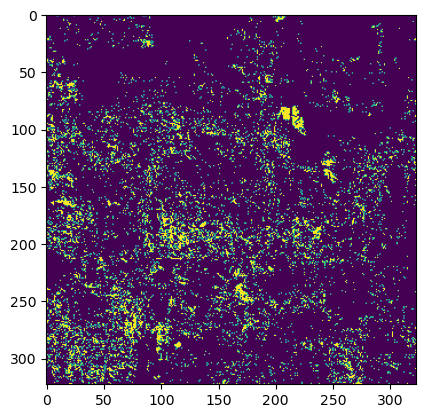

In [201]:
plt.imshow(out.isel(time=150).values)

In [145]:
(out==1).any()

<xarray.DataArray 'NDVI' ()>
array(True)
Coordinates:
    YEAR     int32 2014

In [217]:
hls_ds = hls_ds.where(out==0)

In [218]:
from hlsstack.hls_funcs.predict import pred_bm
from hlsstack.models.load import load_model

In [220]:
mod_bm = load_model('cper_biomass')
# create biomass array
xr_bm = hls_ds.map_blocks(pred_bm, 
                          template=hls_ds['NIR1'],
                          kwargs=dict(model=mod_bm)).where(hls_ds['NIR1'].notnull())#.compute()
xr_bm.name = 'Biomass'

In [226]:
from hlsstack.hls_funcs.smooth import smooth_xr, despike_ts_xr

In [224]:
xr_bm

<xarray.DataArray 'Biomass' (time: 365, y: 323, x: 323)>
dask.array<where, shape=(365, 323, 323), dtype=float64, chunksize=(365, 20, 20), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01 2014-01-02 ... 2014-12-31
  * y        (y) float64 4.524e+06 4.524e+06 4.524e+06 ... 4.515e+06 4.515e+06
  * x        (x) float64 5.176e+05 5.176e+05 5.177e+05 ... 5.272e+05 5.273e+05
    YEAR     int32 2014
Attributes:
    transform:         [ 3.000000e+01 -0.000000e+00  5.083050e+05 -0.000000e+...
    crs:               +init=epsg:32613
    res:               [30. 30.]
    is_tiled:          0
    nodatavals:        nan
    scales:            1.0
    offsets:           0.0
    bands:             1
    byte_order:        0
    data_type:         2
    description:       predicted fine resolution reflectance for sub_nbar.033...
    file_type:         ENVI Standard
    header_offset:     0
    interleave:        bsq
    lines:             1000
    samples:           1000
    sensor_type:       Unknown
    wavelength_units:  Unknown
    x_start:           1
    y_start:           1

In [227]:
dat_out_da = despike_ts_xr(xr_bm,
                           dat_thresh=150, 
                           mask_outliers=True,
                           z_thresh=5.0,
                           iters=2,
                           dims=['time'])
dat_out_da = smooth_xr(xr_bm, 
                       dims=['time'], 
                       kwargs={'double': True, 'limit': 91, 'window2': 45})

In [229]:
test1 = xr_bm.isel(x=160, y=250).values
test2 = dat_out_da.isel(x=160, y=250).values
#test3 = hls_ds['NDVI_smooth'].isel(x=160, y=250).values

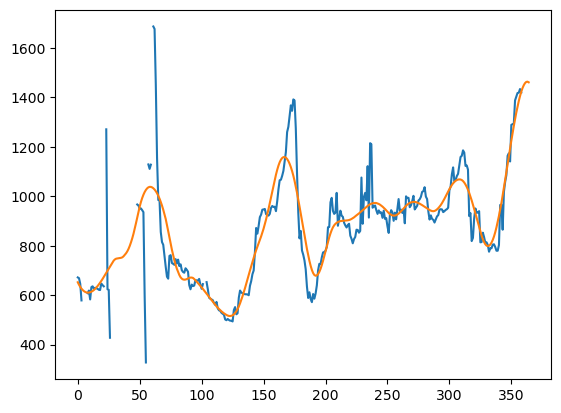

In [230]:
fig, ax = plt.subplots()
ax.plot(test1)
ax.plot(test2)
#ax.plot(test3)

In [214]:
hls_ds['NDVI_smooth'] = smooth_xr(hls_ds['NDVI'].where(out==0), dims=['time'], kwargs={'double': False, 'window2': 31})

In [215]:
test1 = hls_ds['NDVI'].isel(x=160, y=250).values
test2 = hls_ds['NDVI'].where(out==0).isel(x=160, y=250).values
test3 = hls_ds['NDVI_smooth'].isel(x=160, y=250).values
#test3 = despike_lmf_mask(test1)

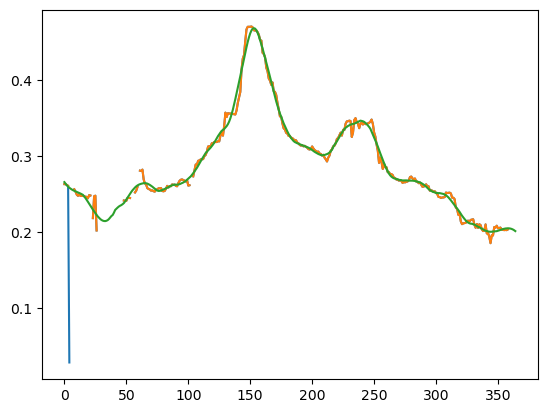

In [216]:
fig, ax = plt.subplots()
ax.plot(test1)
ax.plot(test2)
ax.plot(test3)

In [176]:
low_prominence = 0.05
min_prominence = 0.2
ts = pd.Series(test1*-1.0).interpolate()
pks = find_peaks(ts, prominence=low_prominence)
for i in range(len(pks[0])):
    if pks[1]['prominences'][i] > min_prominence:
        #print(i)
        pk = pks[0][i]
        if i > 0 and pks[1]['prominences'][i-1] < min_prominence:
            left_b = max(pks[1]['left_bases'][i], pks[1]['right_bases'][i-1])
        else:
            left_b = pks[1]['left_bases'][i]
        if i < len(pks) and pks[1]['prominences'][i+1] < min_prominence:
            right_b = min(pks[1]['right_bases'][i], pks[1]['left_bases'][i+1])
        else:
            right_b = pks[1]['right_bases'][i]
        
        ts_sub = ts[left_b:right_b]

        slp, xcpt = np.polyfit([left_b, right_b], ts_sub[[left_b, right_b-1]], 1)
        trend = ts_sub.iloc[0] + slp*np.arange(0, len(ts_sub))
    
        trend_diff = ts_sub - trend
        ts_sub_masked = ts_sub.copy()
        ts_sub_masked[trend_diff > 0] = np.nan
        ts.loc[ts_sub_masked[ts_sub_masked.isnull()].index] = np.nan

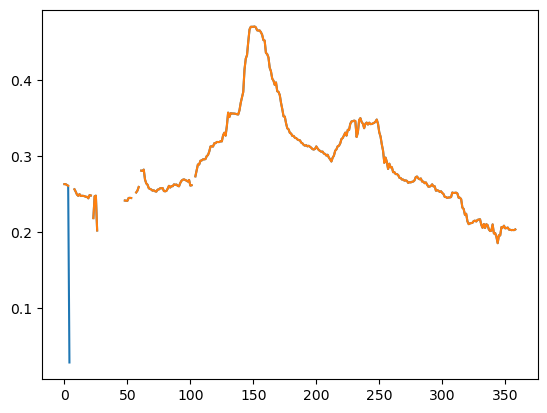

In [182]:
test_mask = despike_lmf_mask(test1)
test2 = test1.copy()
test2[test_mask == 1] = np.nan
plt.plot(test1)
plt.plot(test2)

In [254]:
i = 2
if pks[1]['prominences'][i] > 500:
    pk = pks[0][i]
    if i > 0 and pks[1]['prominences'][i-1] < 500:
        left_b = max(pks[1]['left_bases'][i], pks[1]['right_bases'][i-1])
    else:
        left_b = pks[1]['left_bases'][i]
    if i < len(pks) and pks[1]['prominences'][i+1] < 500:
        right_b = min(pks[1]['right_bases'][i], pks[1]['left_bases'][i+1])
    else:
        right_b = pks[1]['right_bases'][i]
    
    ts_sub = ts[left_b:right_b]
    
    slp, xcpt = np.polyfit([left_b, right_b], ts_sub[[left_b, right_b-1]], 1)
    
    trend = ts_sub.iloc[0] + slp*np.arange(0, len(ts_sub))
    
    trend_diff = ts_sub - trend
    ts_sub_masked = ts_sub.copy()
    ts_sub_masked[trend_diff > np.mean(trend_diff)] = np.nan

In [274]:
#ts_sub_masked[trend_diff > np.mean(trend_diff)]
#ts.loc[ts_sub_masked[ts_sub_masked.isnull()].index] = np.nan
ts.loc[ts_sub_masked[ts_sub_masked.isnull()].index]

58    -1987.0
59    -1775.0
60    -1725.5
61    -1676.0
62    -1683.0
63    -1505.0
64    -2217.0
65    -2387.0
99    -3578.0
100   -3498.0
101   -3525.0
102   -3534.0
103   -3663.0
104   -3675.0
105   -3729.0
106   -3754.0
107   -3769.0
108   -3775.0
109   -3751.0
110   -3771.0
111   -3786.0
112   -3812.0
dtype: float64

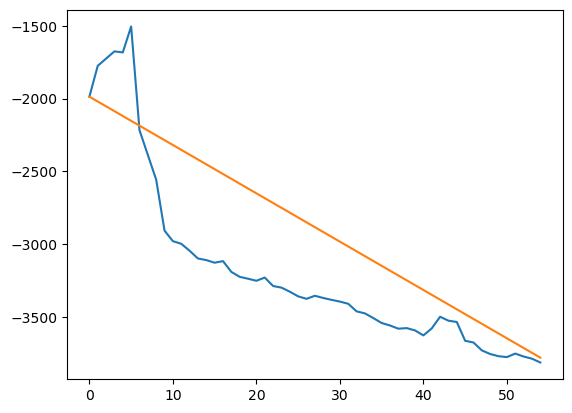

In [256]:
fig, ax = plt.subplots()
#ax.plot(trend_diff)
ax.plot(ts_sub.values)
ax.plot(trend)
#ax.plot(ts_sub_masked)

In [240]:
pks[1]['right_bases'][i-1]

160

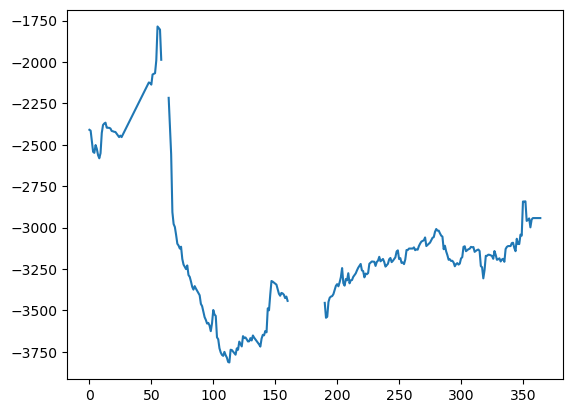

In [289]:
plt.plot(ts)

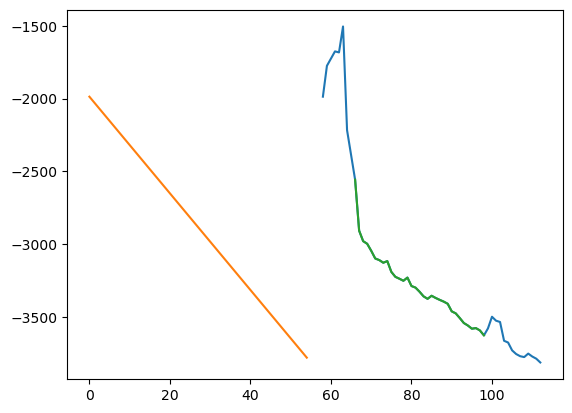

In [261]:
fig, ax = plt.subplots()
ax.plot(ts_sub)
ax.plot(trend)
ax.plot(ts_sub_masked)
#ax.plot(np.arange(cut_left, cut_right), ts_sub[cut_left:cut_right])

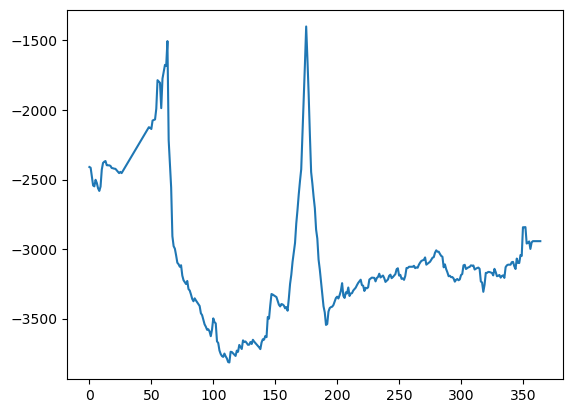

In [262]:
plt.plot(ts)

In [33]:
from hlsstack.hls_funcs.smooth import double_savgol, despike_ts

In [42]:
test_ds = despike_ts(test, dat_thresh=500, days_thresh=30, mask_outliers=True, z_thresh=5.0)
test_smooth = double_savgol(test_ds, double=False)

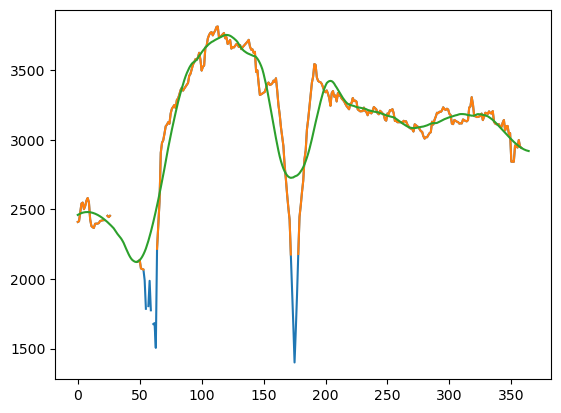

In [43]:
fig, ax = plt.subplots()
ax.plot(test)
ax.plot(test_ds)
ax.plot(test_smooth)